# Predict using **XGBoost**

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from scipy import stats
import statsmodels.api as sm
import statsmodels.stats.api as sms
import statsmodels.stats.api as sms
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

## Load Data

In [ ]:
norm_df = pd.read_csv('../data/processed/5_normalized_data.csv')
smoten_df = pd.read_csv('../data/processed/5_smoten_data.csv')

In [3]:
norm_df.head(3)

,Age,Gender,Education,Nscore,Escore,Oscore,AScore,Cscore,Impulsive,SS,Cannabis
0,0.500963,0.99841,-2.111593,0.31287,-0.57545,-0.58331,-0.91699,-0.00665,-0.21712,-1.18084,0
1,-0.324019,0.99841,-2.549090,-0.67825,1.93886,1.43533,0.76096,-0.14277,-0.71126,-0.21575,4
2,0.500963,0.99841,0.075895,-0.46725,0.80523,-0.84732,-1.62090,-1.01450,-1.37983,0.40148,3


In [4]:
smoten_df.head(3)

,Age,Gender,Education,Nscore,Escore,Oscore,AScore,Cscore,Impulsive,SS,Cannabis
0,0.500963,0.99841,-2.111593,0.31287,-0.57545,-0.58331,-0.91699,-0.00665,-0.21712,-1.18084,0
1,-0.324019,0.99841,-2.549090,-0.67825,1.93886,1.43533,0.76096,-0.14277,-0.71126,-0.21575,4
2,0.500963,0.99841,0.075895,-0.46725,0.80523,-0.84732,-1.62090,-1.01450,-1.37983,0.40148,3


## Split Data

### Norm Data

In [5]:
norm_target = norm_df['Cannabis']
norm_feature = norm_df.drop('Cannabis', axis=1)
norm_feature.head(1)

,Age,Gender,Education,Nscore,Escore,Oscore,AScore,Cscore,Impulsive,SS
0,0.500963,0.99841,-2.111593,0.31287,-0.57545,-0.58331,-0.91699,-0.00665,-0.21712,-1.18084


In [6]:
X_train_norm, X_test_norm, y_train_norm, y_test_norm = train_test_split(norm_feature, norm_target, test_size=0.2, random_state=42)
print(f'Train shape: {X_train_norm.shape}, Test shape: {X_test_norm.shape}')

Train shape: (1508, 10), Test shape: (377, 10)


### SMOTEN Data

In [7]:
smoten_target = smoten_df['Cannabis']
smoten_feature = smoten_df.drop('Cannabis', axis=1)
smoten_feature.head(1)

,Age,Gender,Education,Nscore,Escore,Oscore,AScore,Cscore,Impulsive,SS
0,0.500963,0.99841,-2.111593,0.31287,-0.57545,-0.58331,-0.91699,-0.00665,-0.21712,-1.18084


In [8]:
X_train_smoten, X_test_smoten, y_train_smoten, y_test_smoten = train_test_split(smoten_feature, smoten_target, test_size=0.2, random_state=42)
print(f'Train shape: {X_train_smoten.shape}, Test shape: {X_test_smoten.shape}')

Train shape: (2592, 10), Test shape: (649, 10)


## Predict

### Predict Norm Data

In [ ]:
xgb_model = XGBRegressor(random_state=42, learning_rate=0.01, max_depth=4,
                        n_estimators=500, subsample=0.7, objective='reg:squarederror') #NOSONAR

In [ ]:
xgb_model.fit(X_train_norm, y_train_norm)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.01, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=500,
             n_jobs=None, num_parallel_tree=None, ...)

In [ ]:
norm_predict = xgb_model.predict(X_test_norm)

In [12]:
norm_predict = np.clip(norm_predict, 0, 6)

In [ ]:
train_score = xgb_model.score(X_train_norm, y_train_norm)
teste_score = xgb_model.score(X_test_norm, y_test_norm)
train_score, teste_score

(0.6105637550354004, 0.3920976519584656)

#### Residual Analysis

In [14]:
resid = y_test_norm - norm_predict
resid.min(), resid.max()

(-5.2064433097839355, 5.168711304664612)

#### Residual Normality

In [15]:
_, p = stats.shapiro(resid)
p

np.float64(0.0004980398407954474)

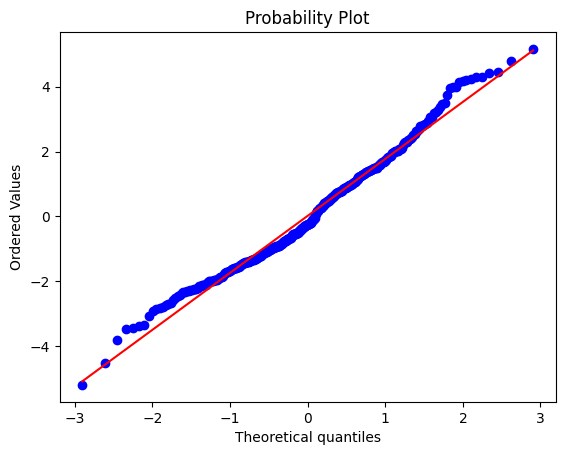

In [16]:
stats.probplot(resid, dist="norm", plot=plt)
plt.show()

<Axes: xlabel='Cannabis', ylabel='Count'>

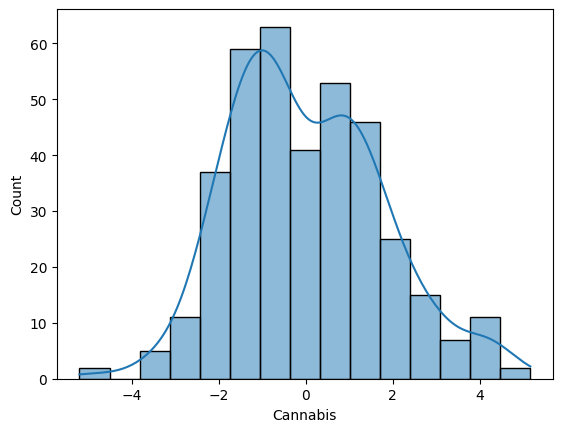

In [17]:
sns.histplot(resid, kde=True)

#### Residual Homocedasticity

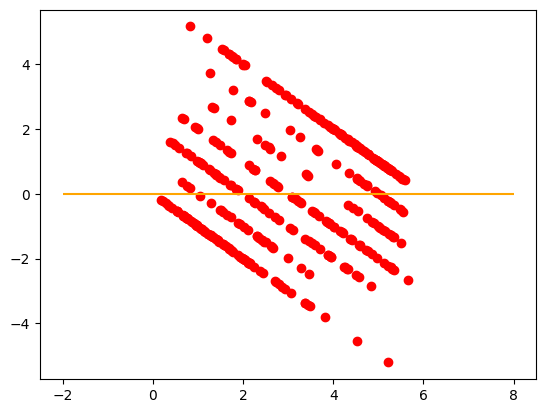

In [ ]:
plt.scatter(y=resid, x=xgb_model.predict(X_test_norm), color='red')
plt.hlines(y=0, xmin=-2, xmax=8, color='orange')

In [19]:
_, p, _, _ = sms.het_breuschpagan(resid, sm.add_constant(X_test_norm))
if p > 0.5:
  print(True, p)
else:
  print(False, p)


True 0.7291427560489798


#### Summary

In [ ]:
r2 = xgb_model.score(X_test_norm, y_test_norm)
mean_abs_err = np.mean(np.abs(resid))

print(f"R²: {r2:.3f}")
print(f"Mean Absolute Error: {mean_abs_err:.3f}")

R²: 0.392
Mean Absolute Error: 1.445


### Predict SMOTEN Data

In [ ]:
xgb_model_smoten = XGBRegressor(random_state=42, learning_rate=0.01, max_depth=4,
                        n_estimators=500, subsample=0.7, objective='reg:squarederror') #NOSONAR

In [ ]:
xgb_model_smoten.fit(X_train_smoten, y_train_smoten)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.01, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=500,
             n_jobs=None, num_parallel_tree=None, ...)

In [ ]:
smoten_predict = xgb_model_smoten.predict(X_test_smoten)

In [24]:
smoten_predict = np.clip(smoten_predict, 0, 6)

In [ ]:
train_score = xgb_model_smoten.score(X_train_smoten, y_train_smoten)
test_score = xgb_model_smoten.score(X_test_smoten, y_test_smoten)
train_score, test_score

(0.6067692041397095, 0.4612940549850464)

#### Residual Analysis

In [26]:
resid_smoten = y_test_smoten - smoten_predict
resid_smoten.min(), resid_smoten.max()

(-5.246192932128906, 5.083241879940033)

#### Residual Normality

In [27]:
_, p_shap = stats.shapiro(resid_smoten)
p_shap

np.float64(9.470623371441681e-05)

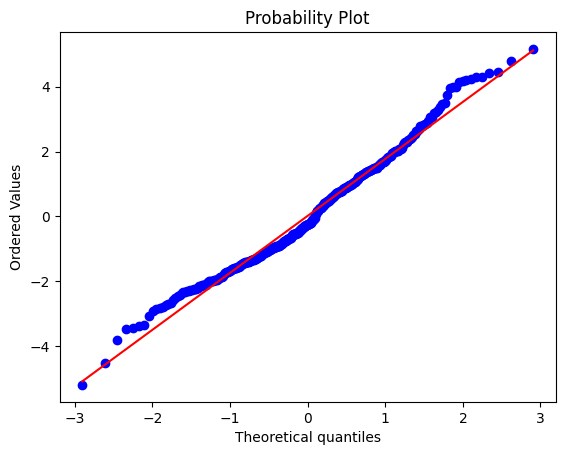

In [28]:
stats.probplot(resid, dist="norm", plot=plt)
plt.show()

<Axes: xlabel='Cannabis', ylabel='Count'>

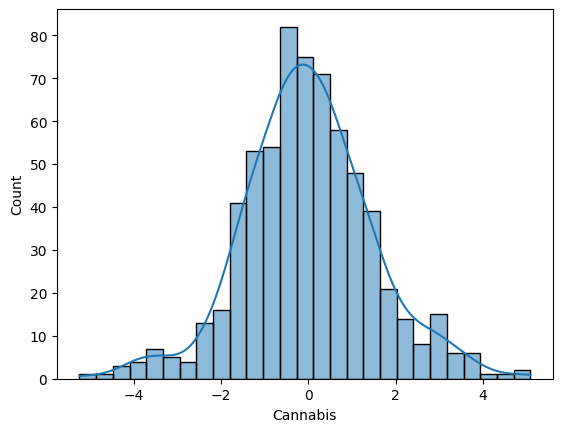

In [29]:
sns.histplot(resid_smoten, kde=True)

#### Residual Homocedasticity

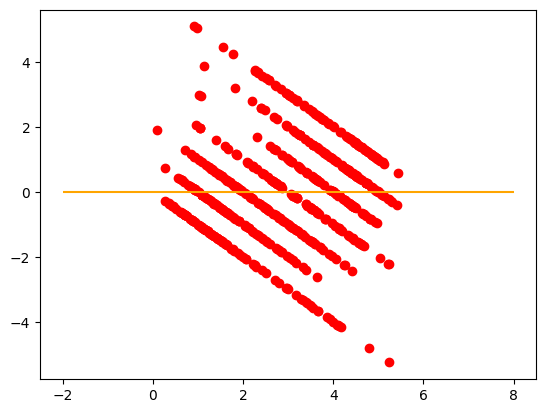

In [ ]:
plt.scatter(y=resid_smoten, x=xgb_model_smoten.predict(X_test_smoten), color='red')
plt.hlines(y=0, xmin=-2, xmax=8, color='orange')

In [31]:
_, p_homo, _, _ = sms.het_breuschpagan(resid_smoten, sm.add_constant(X_test_smoten))
if p_homo > 0.5:
  print(True, p_homo)
else:
  print(False, p_homo)


False 1.4686102250984043e-05


#### Summary

In [ ]:
r2 = xgb_model_smoten.score(X_test_smoten, y_test_smoten)
mean_abs_err = np.mean(np.abs(resid_smoten))

print(f"R²: {r2:.3f}")
print(f"Mean Absolute Error: {mean_abs_err:.3f}")

R²: 0.461
Mean Absolute Error: 1.131
